In [4]:
# Credit to https://www.kaggle.com/wfwiggins203 in https://www.kaggle.com/wfwiggins203/eda-dicom-tags-windowing-head-cts

import time
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
import re
import os
from pathlib import Path
import torch
from torch import nn
from torch.nn import Sigmoid
from torchvision.transforms import functional as F
from torchvision.transforms import Normalize
from math import log
from numpy import e
%matplotlib inline
plt.style.use('grayscale')


In [5]:
ROOT_DIR = "C:/Users/evbruh/Downloads/rsna-intracranial-hemorrhage-detection/"

In [6]:
TRAIN_DIR = ROOT_DIR + 'stage_1_train_images'
TEST_DIR = ROOT_DIR + 'stage_1_test_images'

In [7]:
train_df = pd.read_csv(ROOT_DIR + 'stage_1_train.csv')
print(train_df.shape)
train_df.head(10)

(4045572, 2)


,ID,Label
0,ID_63eb1e259_epidural,0
1,ID_63eb1e259_intraparenchymal,0
2,ID_63eb1e259_intraventricular,0
3,ID_63eb1e259_subarachnoid,0
4,ID_63eb1e259_subdural,0
5,ID_63eb1e259_any,0
6,ID_2669954a7_epidural,0
7,ID_2669954a7_intraparenchymal,0
8,ID_2669954a7_intraventricular,0
9,ID_2669954a7_subarachnoid,0


In [8]:
train_df[['ID', 'Subtype']] = train_df['ID'].str.rsplit(pat='_', n=1, expand=True)
print(train_df.shape)
train_df.head()

(4045572, 3)


,ID,Label,Subtype
0,ID_63eb1e259,0,epidural
1,ID_63eb1e259,0,intraparenchymal
2,ID_63eb1e259,0,intraventricular
3,ID_63eb1e259,0,subarachnoid
4,ID_63eb1e259,0,subdural


In [9]:
def fix_id(img_id, img_dir=TRAIN_DIR):
    if not re.match(r'ID_[a-z0-9]+', img_id):
        sop = re.search(r'[a-z0-9]+', img_id)
        if sop:
            img_id_new = f'ID_{sop[0]}'
            return img_id_new
        else:
            print(img_id)
    return img_id

def id_to_filepath(img_id, img_dir=TRAIN_DIR):
    filepath = f'{img_dir}/{img_id}.dcm' # pydicom doesn't play nice with Path objects
    if os.path.exists(filepath):
        return filepath
    else:
        return 'DNE'
    
def get_patient_data(filepath):
    if filepath != 'DNE':
        dcm_data = pydicom.dcmread(filepath, stop_before_pixels=True)
        return dcm_data.PatientID, dcm_data.StudyInstanceUID, dcm_data.SeriesInstanceUID

In [10]:
train_df['ID'] = train_df['ID'].apply(fix_id)

In [11]:
# this method also handles duplicates gracefully
train_new = train_df.pivot_table(index='ID', columns='Subtype').reset_index()
print(train_new.shape)
train_new.head()

(674258, 7)


ID Label                                             \
Subtype                 any epidural intraparenchymal intraventricular   
0        ID_000039fa0     0        0                0                0   
1        ID_00005679d     0        0                0                0   
2        ID_00008ce3c     0        0                0                0   
3        ID_0000950d7     0        0                0                0   
4        ID_0000aee4b     0        0                0                0   

                               
Subtype subarachnoid subdural  
0                  0        0  
1                  0        0  
2                  0        0  
3                  0        0  
4                  0        0

Subtype
any                 97103
epidural             2761
intraparenchymal    32564
intraventricular    23766
subarachnoid        32122
subdural            42496
dtype: int64


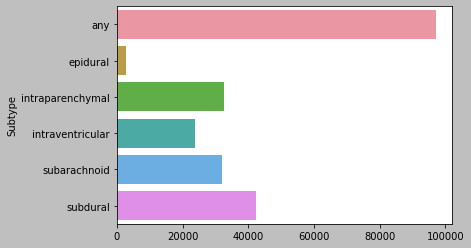

In [12]:
subtype_ct = train_new['Label'].sum(axis=0)
print(subtype_ct)
sns.barplot(x=subtype_ct.values, y=subtype_ct.index)

In [13]:
img_id = train_new['ID'][0]
img_filepath = id_to_filepath(img_id)
print(img_filepath)
train_new['filepath'] = train_new['ID'].apply(id_to_filepath)
train_new.head()

C:/Users/evbruh/Downloads/rsna-intracranial-hemorrhage-detection/stage_1_train_images/ID_000039fa0.dcm


ID Label                                             \
Subtype                 any epidural intraparenchymal intraventricular   
0        ID_000039fa0     0        0                0                0   
1        ID_00005679d     0        0                0                0   
2        ID_00008ce3c     0        0                0                0   
3        ID_0000950d7     0        0                0                0   
4        ID_0000aee4b     0        0                0                0   

                               \
Subtype subarachnoid subdural   
0                  0        0   
1                  0        0   
2                  0        0   
3                  0        0   
4                  0        0   

                                                  filepath  
Subtype                                                     
0        C:/Users/evbruh/Downloads/rsna-intracranial-he...  
1        C:/Users/evbruh/Downloads/rsna-intracranial-he...  
2        C:/Users/evbruh/Downloads/rsna-intracranial-he...  
3        C:/Users/evbruh/Downloads/rsna-intracranial-he...  
4        C:/Users/evbruh/Downloads/rsna-intracranial-he...

In [14]:
dcm_data = pydicom.dcmread(img_filepath)
print(dcm_data)

(0008, 0018) SOP Instance UID                    UI: ID_000039fa0
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_eeaf99e7'
(0020, 000d) Study Instance UID                  UI: ID_134d398b61
(0020, 000e) Series Instance UID                 UI: ID_5f8484c3e0
(0020, 0010) Study ID                            SH: ''
(0020, 0032) Image Position (Patient)            DS: ['-125.000000', '-141.318451', '62.720940']
(0020, 0037) Image Orientation (Patient)         DS: ['1.000000', '0.000000', '0.000000', '0.000000', '0.968148', '-0.250380']
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 512
(0028, 0011) Columns                             US: 512
(0028, 0030) Pixel Spacing                       DS: ['0.488281', '0.488281']
(0028, 0100) Bits Allocated                      US: 16
(0028, 0101) Bits Stored 

In [ ]:
patient, study, series = get_patient_data(img_filepath)
print(patient, study, series)

In [ ]:
hem_types = ['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']

def load_random_images():
    image_names = [list(train_new[train_new['Label', h_type] == 1].sample(1)['filepath'])[0] for h_type in hem_types]
    image_names += list(train_new[train_new['Label', 'any'] == 0].sample(5)['filepath'])
    return [pydicom.read_file(os.path.join(ROOT_DIR, img_name)) for img_name in image_names]

def view_images(images):
    width = 5
    height = 2
    fig, axs = plt.subplots(height, width, figsize=(15,5))
    
    for im in range(0, height * width):
        image = images[im]
        i = im // width
        j = im % width
        axs[i,j].imshow(image, cmap=plt.cm.bone) 
        axs[i,j].axis('off')
        title = hem_types[im] if im < len(hem_types) else 'normal'
        axs[i,j].set_title(title)

    plt.show()
    

In [ ]:
imgs = load_random_images()

In [ ]:

def _normalize(x):
    x_max = x.max()
    x_min = x.min()
    if x_max != x_min:
        z = (x - x_min) / (x_max - x_min)
        return z
    return np.zeros(x.shape)

def sigmoid_window(img, window_center, window_width, U=1.0, eps=(1.0 / 255.0), desired_size=(256, 256)):
    intercept, slope = img.RescaleIntercept, img.RescaleSlope
    img = img.pixel_array * slope + intercept
    
    # resizing already to save computation
    img = cv2.resize(img, desired_size[:2], interpolation=cv2.INTER_LINEAR)
    
    ue = log((U / eps) - 1.0)
    W = (2 / window_width) * ue
    b = ((-2 * window_center) / window_width) * ue
    z = W * img + b
    img = U / (1 + np.power(np.e, -1.0 * z))
    
    img = _normalize(img)
    
    return img

def sigmoid_windowing_0(img, desired_size=(512, 512)):
    brain_img = sigmoid_window(img, 40, 80, desired_size=desired_size)
    subdural_img = sigmoid_window(img, 80, 200, desired_size=desired_size)
    bone_img = sigmoid_window(img, 600, 2000, desired_size=desired_size)
    
    bsb_img = np.zeros((brain_img.shape[0], brain_img.shape[1], 3))
    bsb_img[:, :, 0] = brain_img
    bsb_img[:, :, 1] = subdural_img
    bsb_img[:, :, 2] = bone_img
    return bsb_img


In [ ]:
start = time.time()
view_images([sigmoid_windowing_0(img) for img in imgs])
end = time.time()
print(end-start)


In [ ]:
start = time.time()
out2 = sigmoid_windowing_0(imgs[0])
end = time.time()
print(round(end-start, 6))


In [ ]:
device = torch.cuda.current_device()


U=1.0
eps=(1.0 / 255.0)
ue = log((U / eps) - 1.0)


def _normalize(x):
    x_max = x.max()
    x_min = x.min()
    if x_max != x_min:
        z = (x - x_min) / (x_max - x_min)
        return z
    return torch.zeros(x.shape).astype(x.dtype)


def sigmoid_window_tensor(tens, window_center, window_width):
    
    W = (2 / window_width) * ue
    b = ((-2 * window_center) / window_width) * ue
    
    return _normalize(U / (1 + e**(-1.0 * (W * tens + b))))


def sigmoid_bsb_window_tensor(tens):
    tens[:, :, 0] = sigmoid_window_tensor(tens[:, :, 0], 40, 80)
    tens[:, :, 1] = sigmoid_window_tensor(tens[:, :, 1], 80, 200)
    tens[:, :, 2] = sigmoid_window_tensor(tens[:, :, 2], 600, 2000)
    
    return tens

def sigmoid_windowing_1(dcm, desired_size=(512, 512)):
    slope, intercept, data  = dcm.RescaleSlope, dcm.RescaleIntercept, dcm.pixel_array
    data = torch.Tensor(data.astype('float32')).to(device) * slope + intercept
    data = data.view(desired_size[0], desired_size[1], -1).repeat(1, 1, 3)
    return sigmoid_bsb_window_tensor(data)


start = time.time()
out1 = sigmoid_windowing_1(imgs[0])
end = time.time()
print(out1.is_cuda, out1.shape, out1.min(), out1.max(), out1.mean(), round(end-start, 6))
plt.imshow((255*out1).cpu().numpy().astype('uint8'))
    

### Parallelizing 3 window mapping

In [ ]:

import random
import threading
from random import random as rnd, shuffle
from torchvision import transforms
from scipy.stats import truncnorm, uniform
from torchvision.transforms.functional import adjust_brightness, adjust_contrast, resized_crop, rotate

eps = (1.0 / 255.0)
ue = log((1.0 / eps) - 1.0)


class sigmoid_windowing(nn.Module):
    
    
    def __init__(self):
    
        super(sigmoid_windowing, self).__init__()
    
        self.eps = eps
        self.ue = ue
        self.e = e
    
        self.w0 = (2 / 80) * ue
        self.b0 = ((-2 * 40) / 80) * ue
    
        self.w1 = (2 / 200) * ue
        self.b1 = ((-2 * 80) / 200) * ue
    
        self.w2 = (2 / 2000) * ue
        self.b2 = ((-2 * 600) / 2000) * ue
        
        self.vdim = (512, 512, -1)
        
        self.n = Normalize(mean = [0, 0, 0],
                           std = [1, 1, 1])
    
    
    def forward(self, dcm):

        y = torch.Tensor(dcm.pixel_array.astype('float32')).to(device) * dcm.RescaleSlope + dcm.RescaleIntercept
        
        y0 = (1.0 / (1 + self.e**(-1.0 * (self.w0 * y + self.b0)))).view(self.vdim)
        y1 = (1.0 / (1 + self.e**(-1.0 * (self.w1 * y + self.b1)))).view(self.vdim)
        y2 = (1.0 / (1 + self.e**(-1.0 * (self.w2 * y + self.b2)))).view(self.vdim)

        return self.n(torch.cat((y0, y1, y2), 2))
    

class StoppableThread(threading.Thread):
    """Thread class with a stop() method. The thread itself has to check
    regularly for the stopped() condition."""

    def __init__(self):
        super(StoppableThread, self).__init__()
        self._stop_event = threading.Event()

    def stop(self):
        self._stop_event.set()

    def stopped(self):
        return self._stop_event.is_set()

    
class Preprocess(StoppableThread):
    
    def __init__(self):
        
        self.windower = sigmoid_windowing()
        
        random_resized_crop = lambda x, d: F.resized_crop(x, x.size[0]//2-d, x.size[1]//2-d, d*2, d*2, size=(x.size[0], x.size[1]))
        
        brightness_params = truncnorm(1-.08, 1+.08), .5
        contrast_params = truncnorm(1-.08, 1+.08), .5
        random_resized_params = uniform(.7*512//2, .3*512//2), 0
        rotate_params = uniform(-30, 60), .3
        
        self.FT = [(adjust_brightness, brightness_params),
                   (adjust_contrast, contrast_params),
                   (random_resized_crop, random_resized_params),
                   (rotate, rotate_params)
                  ]
        
        self.normalize = lambda x: F.normalize(x, (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        
    def __call__(self, dcm):
        x = self.windower(dcm)
        x = F.to_pil_image((255*x).cpu().numpy().astype('uint8'))
        if rnd() < .5:
            x = F.hflip(x)
        if rnd() < .5:
            x = F.vflip(x)
        shuffle(self.FT)
        for ft, (d, p) in self.FT:
            if rnd() < p:
                x = ft(x, d.rvs())
#         x_tens = self.normalize(F.to_tensor(x).cuda())
        return x#, x_tens
    
    
thrd = Preprocess()  

In [ ]:

start = time.time()
out3 = thrd.__call__(imgs[4])
end = time.time()
plt.imshow(out3)
print(end-start)
# print(out3_tens.is_cuda, out3_tens.shape, out3_tens.min(), out3_tens.max(), out3_tens.mean(), round(end-start, 6))

In [ ]:
start = time.time()
view_images([thrd.__call__(img) for img in imgs])
end = time.time()
print(end-start)
